# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = '/input'

import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Extracting mnist: 100%|██████████| 60.0K/60.0K [00:10<00:00, 5.82KFile/s]


Extracting celeba...


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

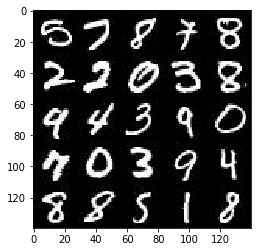

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

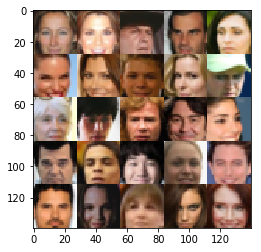

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    input_real_images = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels))
    input_z = tf.placeholder(tf.float32, (None, z_dim))
    learning_rate = tf.placeholder(tf.float32)

    return input_real_images, input_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### LeakyRelu

In [6]:
def leaky_relu(x, alpha=0.2, name='leaky_relu'):

    return tf.maximum(x, alpha * x, name=name)

### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [12]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    
    is_train = True
    
    keep_prob = 0.8
    rate = 1.0 - keep_prob
    
    with tf.variable_scope('discriminator', reuse=reuse):
        
        # Input layer is 28x28x3
        h1 = tf.layers.conv2d(images, 64, 5, 2, 'same', kernel_initializer=tf.contrib.layers.xavier_initializer_conv2d())
        leaky_relu1 = leaky_relu(h1)
        dropout1 = tf.layers.dropout(leaky_relu1, rate, training=is_train)
        # 14x14x64
        
        h2 = tf.layers.conv2d(dropout1, 128, 5, 2, 'same', kernel_initializer=tf.contrib.layers.xavier_initializer_conv2d())
        bn2 = tf.layers.batch_normalization(h2, training=is_train)
        leaky_relu2 = leaky_relu(bn2)
        dropout2 = tf.layers.dropout(leaky_relu2, rate, training=is_train)
        # 7x7x128
     
        h3 = tf.layers.conv2d(dropout2, 256, 5, 2, 'same', kernel_initializer=tf.contrib.layers.xavier_initializer_conv2d())
        bn3 = tf.layers.batch_normalization(h3, training=is_train)
        leaky_relu3 = leaky_relu(bn3)
        dropout3 = tf.layers.dropout(leaky_relu3, rate, training=is_train)
        # 4x4x256

        # Flatten it
        flat = tf.contrib.layers.flatten(dropout3)
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
        
        return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [13]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    
    reuse = not is_train
    keep_prob = 0.7
    rate = 1.0 - keep_prob
    
    with tf.variable_scope('generator', reuse=reuse):
        
        # First fully connected layer
        # Reshape it to start the convolutional stack
        h1 = tf.layers.dense(z, 7*7*512)
        h1 = tf.reshape(h1, (-1, 7, 7, 512))
        bn1 = tf.layers.batch_normalization(h1, training=is_train)
        leaky_relu1 = leaky_relu(bn1)
        dropout = tf.layers.dropout(leaky_relu1, rate, training=is_train)
        # 7x7x512 now
        
        h2 = tf.layers.conv2d_transpose(leaky_relu1, 256, 5, 1, 'same', kernel_initializer=tf.contrib.layers.xavier_initializer_conv2d())
        bn2 = tf.layers.batch_normalization(h2, training=is_train)
        leaky_relu2 = leaky_relu(bn2)
        dropout = tf.layers.dropout(leaky_relu2, rate, training=is_train)
        # 7x7x256 now
        
        h3 = tf.layers.conv2d_transpose(leaky_relu2, 128, 5, 1, 'same', kernel_initializer=tf.contrib.layers.xavier_initializer_conv2d())
        bn3 = tf.layers.batch_normalization(h3, training=is_train)
        leaky_relu3 = leaky_relu(bn3)
        dropout = tf.layers.dropout(leaky_relu3, rate, training=is_train)
        # 7x7x128 now
        
        h4 = tf.layers.conv2d_transpose(leaky_relu3, 64, 5, 2, 'same', kernel_initializer=tf.contrib.layers.xavier_initializer_conv2d())
        bn4 = tf.layers.batch_normalization(h4, training=is_train)
        leaky_relu4 = leaky_relu(bn4)
        dropout = tf.layers.dropout(leaky_relu4, rate, training=is_train)
        # 14x14x64 now

        logits = tf.layers.conv2d_transpose(dropout, out_channel_dim, 5, 2, padding='same', kernel_initializer=tf.contrib.layers.xavier_initializer_conv2d())
        
        # 28x28xout_channel_dim now
        out = tf.tanh(logits)

    return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [14]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    
    smooth = 0.1
    
    g_model = generator(input_z, out_channel_dim)
    
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, True)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(
            labels=tf.ones_like(d_model_real)*(1.0 - smooth), logits=d_logits_real))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(
            labels=tf.zeros_like(d_model_fake), logits=d_logits_fake))
    
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(
            labels=tf.ones_like(d_model_fake), logits=d_logits_fake))

    d_loss = d_loss_real + d_loss_fake
    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [15]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    
    # Code from DCGAN repository of Udacity DLND
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(
            learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(
            learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [16]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [17]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    
    # image_width: data_shape[1]
    # image_height: data_shape[2]
    # image_channels: data_shape[3]
    # out_channel_dim = image_channels
    input_real, input_z, lr = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)
    
    d_loss, g_loss = model_loss(input_real, input_z, data_shape[3])
    d_opt, g_opt = model_opt(d_loss, g_loss, lr, beta1)
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            steps = 0
            for batch_images in get_batches(batch_size):
                steps += 1
                batch_images *= 2
                z_sample = np.random.uniform(-1, 1, (batch_size, z_dim))
                
                _ = sess.run(d_opt, feed_dict={input_real: batch_images, input_z: z_sample, lr: learning_rate})
                _ = sess.run(g_opt, feed_dict={input_real: batch_images, input_z: z_sample, lr: learning_rate})
                _ = sess.run(g_opt, feed_dict={input_real: batch_images, input_z: z_sample, lr: learning_rate})
                # _ = sess.run(g_opt, feed_dict={input_real: batch_images, input_z: z_sample, lr: learning_rate})
                
                if steps % 10 == 0:
                    train_loss_d = d_loss.eval({input_z: z_sample, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: z_sample})
                    
                    print("Epoch {}/{}...".format(epoch_i+1, epochs),
                          "Batch {}...".format(steps),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                
                if steps % 100 == 0:
                    show_generator_output(sess, show_n_images, input_z, data_shape[3], data_image_mode)

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Batch 10... Discriminator Loss: 3.4615... Generator Loss: 0.6195
Epoch 1/2... Batch 20... Discriminator Loss: 2.4676... Generator Loss: 1.6412
Epoch 1/2... Batch 30... Discriminator Loss: 1.7075... Generator Loss: 2.3956
Epoch 1/2... Batch 40... Discriminator Loss: 1.9781... Generator Loss: 1.1102
Epoch 1/2... Batch 50... Discriminator Loss: 1.6133... Generator Loss: 0.8966
Epoch 1/2... Batch 60... Discriminator Loss: 1.7743... Generator Loss: 0.4433
Epoch 1/2... Batch 70... Discriminator Loss: 1.9398... Generator Loss: 0.3673
Epoch 1/2... Batch 80... Discriminator Loss: 1.5642... Generator Loss: 0.6285
Epoch 1/2... Batch 90... Discriminator Loss: 1.6292... Generator Loss: 0.7085
Epoch 1/2... Batch 100... Discriminator Loss: 1.6680... Generator Loss: 0.4755


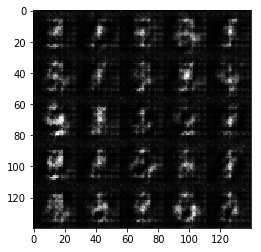

Epoch 1/2... Batch 110... Discriminator Loss: 1.4865... Generator Loss: 0.5682
Epoch 1/2... Batch 120... Discriminator Loss: 1.6595... Generator Loss: 0.5215
Epoch 1/2... Batch 130... Discriminator Loss: 1.6009... Generator Loss: 0.4519
Epoch 1/2... Batch 140... Discriminator Loss: 1.5717... Generator Loss: 0.5913
Epoch 1/2... Batch 150... Discriminator Loss: 1.7178... Generator Loss: 0.3783
Epoch 1/2... Batch 160... Discriminator Loss: 1.5211... Generator Loss: 0.6731
Epoch 1/2... Batch 170... Discriminator Loss: 1.5590... Generator Loss: 0.5255
Epoch 1/2... Batch 180... Discriminator Loss: 1.5299... Generator Loss: 0.9206
Epoch 1/2... Batch 190... Discriminator Loss: 1.6517... Generator Loss: 1.1140
Epoch 1/2... Batch 200... Discriminator Loss: 1.6183... Generator Loss: 1.2025


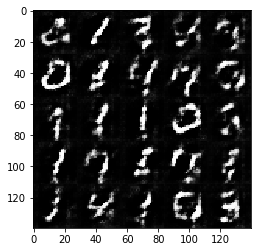

Epoch 1/2... Batch 210... Discriminator Loss: 1.6695... Generator Loss: 1.1803
Epoch 1/2... Batch 220... Discriminator Loss: 1.4645... Generator Loss: 1.0265
Epoch 1/2... Batch 230... Discriminator Loss: 1.5794... Generator Loss: 1.1550
Epoch 1/2... Batch 240... Discriminator Loss: 1.5054... Generator Loss: 1.0348
Epoch 1/2... Batch 250... Discriminator Loss: 1.4428... Generator Loss: 1.0739
Epoch 1/2... Batch 260... Discriminator Loss: 1.5397... Generator Loss: 1.0208
Epoch 1/2... Batch 270... Discriminator Loss: 1.4671... Generator Loss: 0.9873
Epoch 1/2... Batch 280... Discriminator Loss: 1.5636... Generator Loss: 1.1418
Epoch 1/2... Batch 290... Discriminator Loss: 1.5308... Generator Loss: 1.0595
Epoch 1/2... Batch 300... Discriminator Loss: 1.4429... Generator Loss: 1.0580


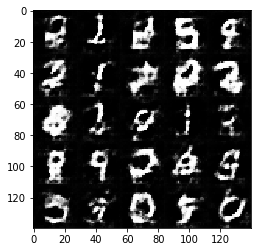

Epoch 1/2... Batch 310... Discriminator Loss: 1.5924... Generator Loss: 0.9707
Epoch 1/2... Batch 320... Discriminator Loss: 1.5484... Generator Loss: 0.9508
Epoch 1/2... Batch 330... Discriminator Loss: 1.6104... Generator Loss: 0.4250
Epoch 1/2... Batch 340... Discriminator Loss: 1.5523... Generator Loss: 0.6418
Epoch 1/2... Batch 350... Discriminator Loss: 1.4610... Generator Loss: 0.6398
Epoch 1/2... Batch 360... Discriminator Loss: 1.4172... Generator Loss: 0.6996
Epoch 1/2... Batch 370... Discriminator Loss: 1.5944... Generator Loss: 1.1540
Epoch 1/2... Batch 380... Discriminator Loss: 1.5753... Generator Loss: 1.0136
Epoch 1/2... Batch 390... Discriminator Loss: 1.5027... Generator Loss: 0.8989
Epoch 1/2... Batch 400... Discriminator Loss: 1.4558... Generator Loss: 0.8940


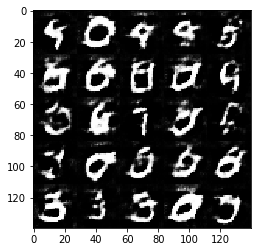

Epoch 1/2... Batch 410... Discriminator Loss: 1.5425... Generator Loss: 0.9592
Epoch 1/2... Batch 420... Discriminator Loss: 1.5394... Generator Loss: 0.8267
Epoch 1/2... Batch 430... Discriminator Loss: 1.4403... Generator Loss: 0.9022
Epoch 1/2... Batch 440... Discriminator Loss: 1.5744... Generator Loss: 1.1302
Epoch 1/2... Batch 450... Discriminator Loss: 1.5823... Generator Loss: 1.1281
Epoch 1/2... Batch 460... Discriminator Loss: 1.5091... Generator Loss: 1.0862
Epoch 1/2... Batch 470... Discriminator Loss: 1.4485... Generator Loss: 0.8217
Epoch 1/2... Batch 480... Discriminator Loss: 1.4903... Generator Loss: 1.1234
Epoch 1/2... Batch 490... Discriminator Loss: 1.5068... Generator Loss: 0.9220
Epoch 1/2... Batch 500... Discriminator Loss: 1.4672... Generator Loss: 1.2255


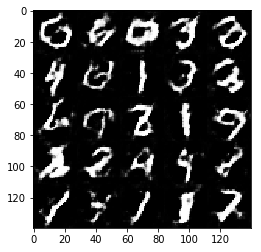

Epoch 1/2... Batch 510... Discriminator Loss: 1.4739... Generator Loss: 0.5537
Epoch 1/2... Batch 520... Discriminator Loss: 1.6394... Generator Loss: 0.4242
Epoch 1/2... Batch 530... Discriminator Loss: 1.4928... Generator Loss: 0.5233
Epoch 1/2... Batch 540... Discriminator Loss: 1.3830... Generator Loss: 0.6764
Epoch 1/2... Batch 550... Discriminator Loss: 1.3978... Generator Loss: 0.7580
Epoch 1/2... Batch 560... Discriminator Loss: 1.4942... Generator Loss: 0.4735
Epoch 1/2... Batch 570... Discriminator Loss: 1.4844... Generator Loss: 0.5863
Epoch 1/2... Batch 580... Discriminator Loss: 1.4794... Generator Loss: 0.4895
Epoch 1/2... Batch 590... Discriminator Loss: 1.4139... Generator Loss: 0.6947
Epoch 1/2... Batch 600... Discriminator Loss: 1.6146... Generator Loss: 0.3980


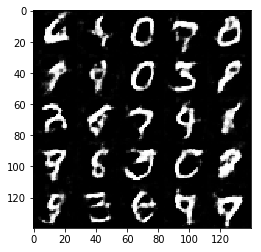

Epoch 1/2... Batch 610... Discriminator Loss: 1.4575... Generator Loss: 0.5972
Epoch 1/2... Batch 620... Discriminator Loss: 1.3995... Generator Loss: 0.8264
Epoch 1/2... Batch 630... Discriminator Loss: 1.4309... Generator Loss: 0.5997
Epoch 1/2... Batch 640... Discriminator Loss: 1.6880... Generator Loss: 0.3784
Epoch 1/2... Batch 650... Discriminator Loss: 1.4439... Generator Loss: 0.7681
Epoch 1/2... Batch 660... Discriminator Loss: 1.4398... Generator Loss: 0.9165
Epoch 1/2... Batch 670... Discriminator Loss: 1.6205... Generator Loss: 1.3506
Epoch 1/2... Batch 680... Discriminator Loss: 1.4105... Generator Loss: 0.7730
Epoch 1/2... Batch 690... Discriminator Loss: 1.4337... Generator Loss: 0.8942
Epoch 1/2... Batch 700... Discriminator Loss: 1.4979... Generator Loss: 1.1904


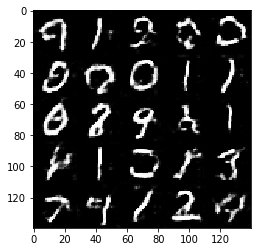

Epoch 1/2... Batch 710... Discriminator Loss: 1.5387... Generator Loss: 1.0541
Epoch 1/2... Batch 720... Discriminator Loss: 1.7566... Generator Loss: 1.4639
Epoch 1/2... Batch 730... Discriminator Loss: 1.3504... Generator Loss: 0.8177
Epoch 1/2... Batch 740... Discriminator Loss: 1.4015... Generator Loss: 1.1285
Epoch 1/2... Batch 750... Discriminator Loss: 1.4169... Generator Loss: 0.9530
Epoch 1/2... Batch 760... Discriminator Loss: 1.4669... Generator Loss: 0.8523
Epoch 1/2... Batch 770... Discriminator Loss: 1.4506... Generator Loss: 0.5974
Epoch 1/2... Batch 780... Discriminator Loss: 1.4733... Generator Loss: 0.5984
Epoch 1/2... Batch 790... Discriminator Loss: 1.3781... Generator Loss: 0.6946
Epoch 1/2... Batch 800... Discriminator Loss: 1.4665... Generator Loss: 0.5803


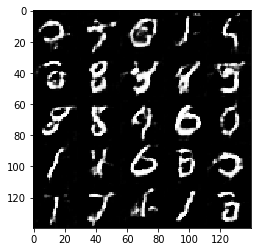

Epoch 1/2... Batch 810... Discriminator Loss: 1.4419... Generator Loss: 0.7423
Epoch 1/2... Batch 820... Discriminator Loss: 1.3881... Generator Loss: 0.7254
Epoch 1/2... Batch 830... Discriminator Loss: 1.4108... Generator Loss: 0.6520
Epoch 1/2... Batch 840... Discriminator Loss: 1.3948... Generator Loss: 0.8765
Epoch 1/2... Batch 850... Discriminator Loss: 1.3767... Generator Loss: 0.7233
Epoch 1/2... Batch 860... Discriminator Loss: 1.4707... Generator Loss: 0.9439
Epoch 1/2... Batch 870... Discriminator Loss: 1.4842... Generator Loss: 1.2952
Epoch 1/2... Batch 880... Discriminator Loss: 1.3733... Generator Loss: 0.8465
Epoch 1/2... Batch 890... Discriminator Loss: 1.4977... Generator Loss: 1.2207
Epoch 1/2... Batch 900... Discriminator Loss: 1.4289... Generator Loss: 1.0893


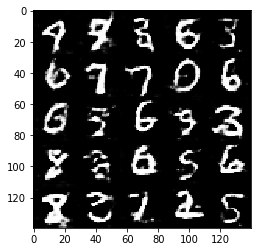

Epoch 1/2... Batch 910... Discriminator Loss: 1.3844... Generator Loss: 0.7750
Epoch 1/2... Batch 920... Discriminator Loss: 1.6750... Generator Loss: 1.2935
Epoch 1/2... Batch 930... Discriminator Loss: 1.4067... Generator Loss: 0.8411
Epoch 2/2... Batch 10... Discriminator Loss: 1.4783... Generator Loss: 0.4745
Epoch 2/2... Batch 20... Discriminator Loss: 1.3602... Generator Loss: 0.6158
Epoch 2/2... Batch 30... Discriminator Loss: 1.6112... Generator Loss: 0.3760
Epoch 2/2... Batch 40... Discriminator Loss: 1.4827... Generator Loss: 0.4918
Epoch 2/2... Batch 50... Discriminator Loss: 1.4153... Generator Loss: 0.8157
Epoch 2/2... Batch 60... Discriminator Loss: 1.3957... Generator Loss: 0.6742
Epoch 2/2... Batch 70... Discriminator Loss: 1.4805... Generator Loss: 0.6135
Epoch 2/2... Batch 80... Discriminator Loss: 1.3405... Generator Loss: 0.6656
Epoch 2/2... Batch 90... Discriminator Loss: 1.7728... Generator Loss: 0.3212
Epoch 2/2... Batch 100... Discriminator Loss: 1.2990... Gener

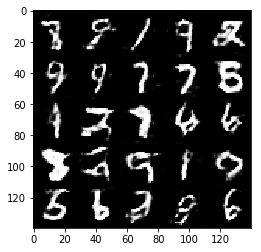

Epoch 2/2... Batch 110... Discriminator Loss: 1.4036... Generator Loss: 0.6936
Epoch 2/2... Batch 120... Discriminator Loss: 1.4578... Generator Loss: 0.5778
Epoch 2/2... Batch 130... Discriminator Loss: 1.4659... Generator Loss: 0.5656
Epoch 2/2... Batch 140... Discriminator Loss: 1.5216... Generator Loss: 0.4626
Epoch 2/2... Batch 150... Discriminator Loss: 1.3613... Generator Loss: 0.7791
Epoch 2/2... Batch 160... Discriminator Loss: 1.4290... Generator Loss: 1.0460
Epoch 2/2... Batch 170... Discriminator Loss: 1.4380... Generator Loss: 0.5717
Epoch 2/2... Batch 180... Discriminator Loss: 1.3295... Generator Loss: 0.8037
Epoch 2/2... Batch 190... Discriminator Loss: 2.1372... Generator Loss: 1.9739
Epoch 2/2... Batch 200... Discriminator Loss: 1.3927... Generator Loss: 0.6670


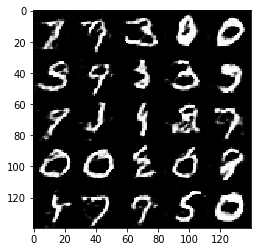

Epoch 2/2... Batch 210... Discriminator Loss: 1.3596... Generator Loss: 0.7476
Epoch 2/2... Batch 220... Discriminator Loss: 1.4031... Generator Loss: 0.7143
Epoch 2/2... Batch 230... Discriminator Loss: 1.4041... Generator Loss: 0.6855
Epoch 2/2... Batch 240... Discriminator Loss: 1.4854... Generator Loss: 0.5588
Epoch 2/2... Batch 250... Discriminator Loss: 1.4088... Generator Loss: 0.5817
Epoch 2/2... Batch 260... Discriminator Loss: 1.3977... Generator Loss: 0.6306
Epoch 2/2... Batch 270... Discriminator Loss: 1.5571... Generator Loss: 0.4150
Epoch 2/2... Batch 280... Discriminator Loss: 1.4633... Generator Loss: 0.5538
Epoch 2/2... Batch 290... Discriminator Loss: 1.4396... Generator Loss: 0.6042
Epoch 2/2... Batch 300... Discriminator Loss: 1.4133... Generator Loss: 0.6262


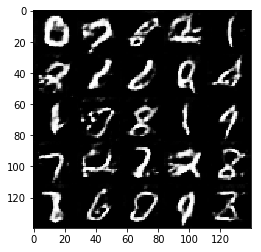

Epoch 2/2... Batch 310... Discriminator Loss: 1.3995... Generator Loss: 0.6134
Epoch 2/2... Batch 320... Discriminator Loss: 1.3978... Generator Loss: 0.7365
Epoch 2/2... Batch 330... Discriminator Loss: 1.5472... Generator Loss: 0.4357
Epoch 2/2... Batch 340... Discriminator Loss: 1.4794... Generator Loss: 0.5498
Epoch 2/2... Batch 350... Discriminator Loss: 1.4634... Generator Loss: 0.6005
Epoch 2/2... Batch 360... Discriminator Loss: 1.4144... Generator Loss: 0.5952
Epoch 2/2... Batch 370... Discriminator Loss: 1.4045... Generator Loss: 0.5797
Epoch 2/2... Batch 380... Discriminator Loss: 1.4951... Generator Loss: 0.4235
Epoch 2/2... Batch 390... Discriminator Loss: 1.5526... Generator Loss: 0.5233
Epoch 2/2... Batch 400... Discriminator Loss: 1.4180... Generator Loss: 0.6493


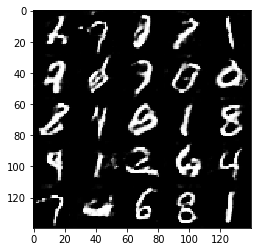

Epoch 2/2... Batch 410... Discriminator Loss: 1.3310... Generator Loss: 1.2471
Epoch 2/2... Batch 420... Discriminator Loss: 1.3592... Generator Loss: 0.8004
Epoch 2/2... Batch 430... Discriminator Loss: 1.5002... Generator Loss: 1.3287
Epoch 2/2... Batch 440... Discriminator Loss: 1.3917... Generator Loss: 1.1415
Epoch 2/2... Batch 450... Discriminator Loss: 1.3629... Generator Loss: 0.8554
Epoch 2/2... Batch 460... Discriminator Loss: 1.4245... Generator Loss: 1.0514
Epoch 2/2... Batch 470... Discriminator Loss: 1.3503... Generator Loss: 1.0183
Epoch 2/2... Batch 480... Discriminator Loss: 1.3234... Generator Loss: 0.7206
Epoch 2/2... Batch 490... Discriminator Loss: 1.5671... Generator Loss: 0.4388
Epoch 2/2... Batch 500... Discriminator Loss: 1.4624... Generator Loss: 0.5275


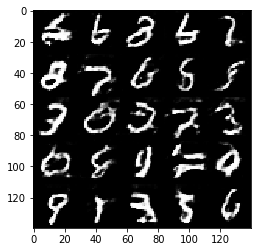

Epoch 2/2... Batch 510... Discriminator Loss: 1.5703... Generator Loss: 0.4640
Epoch 2/2... Batch 520... Discriminator Loss: 1.4703... Generator Loss: 0.5745
Epoch 2/2... Batch 530... Discriminator Loss: 1.6076... Generator Loss: 0.4776
Epoch 2/2... Batch 540... Discriminator Loss: 1.3721... Generator Loss: 0.5731
Epoch 2/2... Batch 550... Discriminator Loss: 1.4659... Generator Loss: 0.5440
Epoch 2/2... Batch 560... Discriminator Loss: 1.3698... Generator Loss: 0.7144
Epoch 2/2... Batch 570... Discriminator Loss: 1.4463... Generator Loss: 0.7021
Epoch 2/2... Batch 580... Discriminator Loss: 1.3380... Generator Loss: 0.7664
Epoch 2/2... Batch 590... Discriminator Loss: 1.4699... Generator Loss: 0.5399
Epoch 2/2... Batch 600... Discriminator Loss: 1.4488... Generator Loss: 0.5378


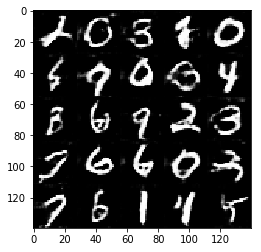

Epoch 2/2... Batch 610... Discriminator Loss: 1.3909... Generator Loss: 0.7064
Epoch 2/2... Batch 620... Discriminator Loss: 1.6673... Generator Loss: 1.4043
Epoch 2/2... Batch 630... Discriminator Loss: 1.3351... Generator Loss: 0.6556
Epoch 2/2... Batch 640... Discriminator Loss: 1.5297... Generator Loss: 0.3912
Epoch 2/2... Batch 650... Discriminator Loss: 1.2819... Generator Loss: 0.7815
Epoch 2/2... Batch 660... Discriminator Loss: 1.2500... Generator Loss: 0.6755
Epoch 2/2... Batch 670... Discriminator Loss: 1.5724... Generator Loss: 0.4144
Epoch 2/2... Batch 680... Discriminator Loss: 1.3750... Generator Loss: 0.5865
Epoch 2/2... Batch 690... Discriminator Loss: 1.3325... Generator Loss: 0.7975
Epoch 2/2... Batch 700... Discriminator Loss: 1.3170... Generator Loss: 0.9770


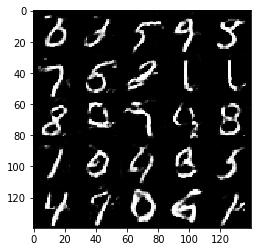

Epoch 2/2... Batch 710... Discriminator Loss: 1.3499... Generator Loss: 0.8145
Epoch 2/2... Batch 720... Discriminator Loss: 1.5441... Generator Loss: 0.4652
Epoch 2/2... Batch 730... Discriminator Loss: 1.4314... Generator Loss: 0.8737
Epoch 2/2... Batch 740... Discriminator Loss: 1.3166... Generator Loss: 0.9672
Epoch 2/2... Batch 750... Discriminator Loss: 1.7005... Generator Loss: 1.6282
Epoch 2/2... Batch 760... Discriminator Loss: 1.3744... Generator Loss: 0.7025
Epoch 2/2... Batch 770... Discriminator Loss: 1.3205... Generator Loss: 0.6958
Epoch 2/2... Batch 780... Discriminator Loss: 1.6190... Generator Loss: 0.3780
Epoch 2/2... Batch 790... Discriminator Loss: 1.3473... Generator Loss: 0.5914
Epoch 2/2... Batch 800... Discriminator Loss: 1.4957... Generator Loss: 0.4553


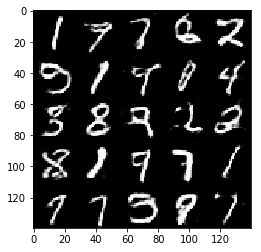

Epoch 2/2... Batch 810... Discriminator Loss: 1.3128... Generator Loss: 0.5812
Epoch 2/2... Batch 820... Discriminator Loss: 1.3975... Generator Loss: 0.6633
Epoch 2/2... Batch 830... Discriminator Loss: 1.3615... Generator Loss: 0.6118
Epoch 2/2... Batch 840... Discriminator Loss: 1.6300... Generator Loss: 0.4471
Epoch 2/2... Batch 850... Discriminator Loss: 1.2244... Generator Loss: 1.3418
Epoch 2/2... Batch 860... Discriminator Loss: 1.3711... Generator Loss: 1.1038
Epoch 2/2... Batch 870... Discriminator Loss: 1.2884... Generator Loss: 1.0820
Epoch 2/2... Batch 880... Discriminator Loss: 1.2645... Generator Loss: 0.6836
Epoch 2/2... Batch 890... Discriminator Loss: 1.4650... Generator Loss: 1.3797
Epoch 2/2... Batch 900... Discriminator Loss: 1.3013... Generator Loss: 0.7090


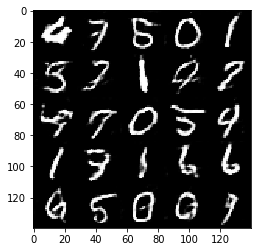

Epoch 2/2... Batch 910... Discriminator Loss: 1.4892... Generator Loss: 0.5221
Epoch 2/2... Batch 920... Discriminator Loss: 1.4969... Generator Loss: 0.5410
Epoch 2/2... Batch 930... Discriminator Loss: 1.1894... Generator Loss: 0.9792


In [18]:
batch_size = 64
z_dim = 100
learning_rate = 0.001
beta1 = 0.3


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Batch 10... Discriminator Loss: 3.7593... Generator Loss: 0.1769
Epoch 1/1... Batch 20... Discriminator Loss: 4.4387... Generator Loss: 0.6261
Epoch 1/1... Batch 30... Discriminator Loss: 1.6875... Generator Loss: 0.7827
Epoch 1/1... Batch 40... Discriminator Loss: 2.0373... Generator Loss: 1.6923
Epoch 1/1... Batch 50... Discriminator Loss: 1.6605... Generator Loss: 0.7825
Epoch 1/1... Batch 60... Discriminator Loss: 1.6791... Generator Loss: 0.6106
Epoch 1/1... Batch 70... Discriminator Loss: 1.8760... Generator Loss: 0.5604
Epoch 1/1... Batch 80... Discriminator Loss: 1.5363... Generator Loss: 0.5011
Epoch 1/1... Batch 90... Discriminator Loss: 1.2843... Generator Loss: 0.8530
Epoch 1/1... Batch 100... Discriminator Loss: 1.8214... Generator Loss: 0.5671


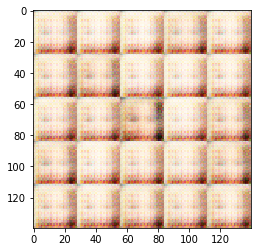

Epoch 1/1... Batch 110... Discriminator Loss: 1.7763... Generator Loss: 0.5814
Epoch 1/1... Batch 120... Discriminator Loss: 1.5080... Generator Loss: 1.3738
Epoch 1/1... Batch 130... Discriminator Loss: 1.7919... Generator Loss: 0.8075
Epoch 1/1... Batch 140... Discriminator Loss: 1.6937... Generator Loss: 0.5629
Epoch 1/1... Batch 150... Discriminator Loss: 1.7375... Generator Loss: 0.8598
Epoch 1/1... Batch 160... Discriminator Loss: 1.7423... Generator Loss: 0.8351
Epoch 1/1... Batch 170... Discriminator Loss: 1.7494... Generator Loss: 1.9974
Epoch 1/1... Batch 180... Discriminator Loss: 1.7850... Generator Loss: 0.6025
Epoch 1/1... Batch 190... Discriminator Loss: 1.7630... Generator Loss: 0.7926
Epoch 1/1... Batch 200... Discriminator Loss: 1.3287... Generator Loss: 0.8849


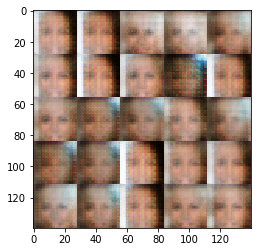

Epoch 1/1... Batch 210... Discriminator Loss: 1.3748... Generator Loss: 0.8047
Epoch 1/1... Batch 220... Discriminator Loss: 1.5336... Generator Loss: 0.6285
Epoch 1/1... Batch 230... Discriminator Loss: 1.6600... Generator Loss: 0.9325
Epoch 1/1... Batch 240... Discriminator Loss: 1.4758... Generator Loss: 0.7345
Epoch 1/1... Batch 250... Discriminator Loss: 1.5460... Generator Loss: 0.6739
Epoch 1/1... Batch 260... Discriminator Loss: 1.5647... Generator Loss: 1.0650
Epoch 1/1... Batch 270... Discriminator Loss: 1.3051... Generator Loss: 0.8370
Epoch 1/1... Batch 280... Discriminator Loss: 1.5279... Generator Loss: 0.9899
Epoch 1/1... Batch 290... Discriminator Loss: 1.7080... Generator Loss: 0.6547
Epoch 1/1... Batch 300... Discriminator Loss: 1.6597... Generator Loss: 0.8163


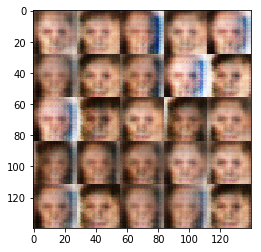

Epoch 1/1... Batch 310... Discriminator Loss: 1.5200... Generator Loss: 0.7730
Epoch 1/1... Batch 320... Discriminator Loss: 1.4006... Generator Loss: 0.9699
Epoch 1/1... Batch 330... Discriminator Loss: 1.4046... Generator Loss: 0.6412
Epoch 1/1... Batch 340... Discriminator Loss: 1.3470... Generator Loss: 0.6732
Epoch 1/1... Batch 350... Discriminator Loss: 1.6841... Generator Loss: 0.6802
Epoch 1/1... Batch 360... Discriminator Loss: 1.7063... Generator Loss: 0.6967
Epoch 1/1... Batch 370... Discriminator Loss: 1.3315... Generator Loss: 0.7592
Epoch 1/1... Batch 380... Discriminator Loss: 1.4240... Generator Loss: 1.2386
Epoch 1/1... Batch 390... Discriminator Loss: 1.3625... Generator Loss: 0.7834
Epoch 1/1... Batch 400... Discriminator Loss: 1.5722... Generator Loss: 1.0124


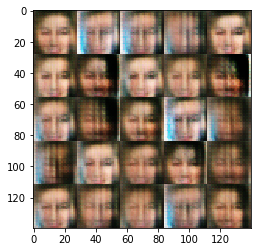

Epoch 1/1... Batch 410... Discriminator Loss: 1.6361... Generator Loss: 0.8299
Epoch 1/1... Batch 420... Discriminator Loss: 1.4321... Generator Loss: 0.8887
Epoch 1/1... Batch 430... Discriminator Loss: 1.4445... Generator Loss: 0.8690
Epoch 1/1... Batch 440... Discriminator Loss: 1.5206... Generator Loss: 0.5949
Epoch 1/1... Batch 450... Discriminator Loss: 1.3801... Generator Loss: 0.7737
Epoch 1/1... Batch 460... Discriminator Loss: 1.4741... Generator Loss: 0.8314
Epoch 1/1... Batch 470... Discriminator Loss: 1.2462... Generator Loss: 0.8198
Epoch 1/1... Batch 480... Discriminator Loss: 1.6301... Generator Loss: 0.8774
Epoch 1/1... Batch 490... Discriminator Loss: 1.4829... Generator Loss: 0.8145
Epoch 1/1... Batch 500... Discriminator Loss: 1.3881... Generator Loss: 0.8206


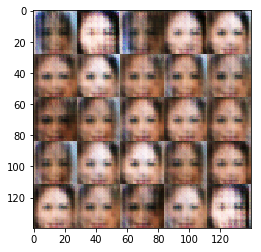

Epoch 1/1... Batch 510... Discriminator Loss: 1.5816... Generator Loss: 0.6021
Epoch 1/1... Batch 520... Discriminator Loss: 1.4871... Generator Loss: 0.8691
Epoch 1/1... Batch 530... Discriminator Loss: 1.4613... Generator Loss: 0.6157
Epoch 1/1... Batch 540... Discriminator Loss: 1.3014... Generator Loss: 0.8328
Epoch 1/1... Batch 550... Discriminator Loss: 1.5326... Generator Loss: 0.8401
Epoch 1/1... Batch 560... Discriminator Loss: 1.7852... Generator Loss: 1.0846
Epoch 1/1... Batch 570... Discriminator Loss: 1.5315... Generator Loss: 0.8778
Epoch 1/1... Batch 580... Discriminator Loss: 1.5434... Generator Loss: 0.8502
Epoch 1/1... Batch 590... Discriminator Loss: 1.3743... Generator Loss: 0.9158
Epoch 1/1... Batch 600... Discriminator Loss: 1.5593... Generator Loss: 0.9106


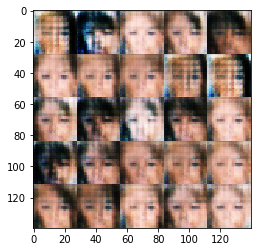

Epoch 1/1... Batch 610... Discriminator Loss: 1.4880... Generator Loss: 0.7674
Epoch 1/1... Batch 620... Discriminator Loss: 1.4897... Generator Loss: 0.8855
Epoch 1/1... Batch 630... Discriminator Loss: 1.5989... Generator Loss: 0.6026
Epoch 1/1... Batch 640... Discriminator Loss: 1.3379... Generator Loss: 1.1867
Epoch 1/1... Batch 650... Discriminator Loss: 1.4585... Generator Loss: 0.7421
Epoch 1/1... Batch 660... Discriminator Loss: 1.4408... Generator Loss: 0.7611
Epoch 1/1... Batch 670... Discriminator Loss: 1.5185... Generator Loss: 0.7685
Epoch 1/1... Batch 680... Discriminator Loss: 1.4878... Generator Loss: 0.7498
Epoch 1/1... Batch 690... Discriminator Loss: 1.3878... Generator Loss: 0.8009
Epoch 1/1... Batch 700... Discriminator Loss: 1.6049... Generator Loss: 0.7519


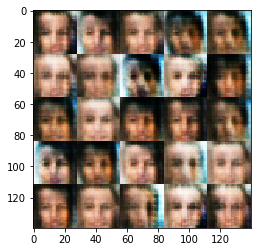

Epoch 1/1... Batch 710... Discriminator Loss: 1.5144... Generator Loss: 0.7541
Epoch 1/1... Batch 720... Discriminator Loss: 1.4311... Generator Loss: 0.7348
Epoch 1/1... Batch 730... Discriminator Loss: 1.4293... Generator Loss: 0.8555
Epoch 1/1... Batch 740... Discriminator Loss: 1.4189... Generator Loss: 0.7371
Epoch 1/1... Batch 750... Discriminator Loss: 1.4225... Generator Loss: 0.8977
Epoch 1/1... Batch 760... Discriminator Loss: 1.6134... Generator Loss: 0.8502
Epoch 1/1... Batch 770... Discriminator Loss: 1.4217... Generator Loss: 0.7787
Epoch 1/1... Batch 780... Discriminator Loss: 1.4314... Generator Loss: 0.7850
Epoch 1/1... Batch 790... Discriminator Loss: 1.3984... Generator Loss: 0.7976
Epoch 1/1... Batch 800... Discriminator Loss: 1.4283... Generator Loss: 0.7565


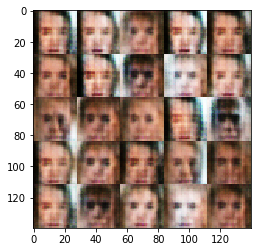

Epoch 1/1... Batch 810... Discriminator Loss: 1.3802... Generator Loss: 0.8449
Epoch 1/1... Batch 820... Discriminator Loss: 1.4073... Generator Loss: 0.7636
Epoch 1/1... Batch 830... Discriminator Loss: 1.3862... Generator Loss: 1.0230
Epoch 1/1... Batch 840... Discriminator Loss: 1.5514... Generator Loss: 0.8188
Epoch 1/1... Batch 850... Discriminator Loss: 1.3880... Generator Loss: 0.7695
Epoch 1/1... Batch 860... Discriminator Loss: 1.3749... Generator Loss: 0.7548
Epoch 1/1... Batch 870... Discriminator Loss: 1.4717... Generator Loss: 0.7777
Epoch 1/1... Batch 880... Discriminator Loss: 1.5350... Generator Loss: 0.8052
Epoch 1/1... Batch 890... Discriminator Loss: 1.3522... Generator Loss: 0.8948
Epoch 1/1... Batch 900... Discriminator Loss: 1.3813... Generator Loss: 0.7650


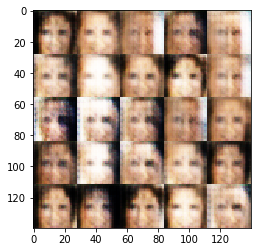

Epoch 1/1... Batch 910... Discriminator Loss: 1.4473... Generator Loss: 0.8183
Epoch 1/1... Batch 920... Discriminator Loss: 1.4320... Generator Loss: 0.7243
Epoch 1/1... Batch 930... Discriminator Loss: 1.3669... Generator Loss: 0.8389
Epoch 1/1... Batch 940... Discriminator Loss: 1.3636... Generator Loss: 0.8116
Epoch 1/1... Batch 950... Discriminator Loss: 1.4398... Generator Loss: 0.8003
Epoch 1/1... Batch 960... Discriminator Loss: 1.4469... Generator Loss: 0.8338
Epoch 1/1... Batch 970... Discriminator Loss: 1.4059... Generator Loss: 0.7667
Epoch 1/1... Batch 980... Discriminator Loss: 1.6024... Generator Loss: 0.8092
Epoch 1/1... Batch 990... Discriminator Loss: 1.4325... Generator Loss: 0.8433
Epoch 1/1... Batch 1000... Discriminator Loss: 1.2894... Generator Loss: 0.7864


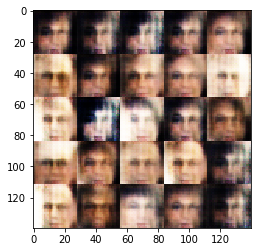

Epoch 1/1... Batch 1010... Discriminator Loss: 1.3893... Generator Loss: 0.8027
Epoch 1/1... Batch 1020... Discriminator Loss: 1.4946... Generator Loss: 0.7650
Epoch 1/1... Batch 1030... Discriminator Loss: 1.4327... Generator Loss: 0.8008
Epoch 1/1... Batch 1040... Discriminator Loss: 1.4545... Generator Loss: 0.8569
Epoch 1/1... Batch 1050... Discriminator Loss: 1.5276... Generator Loss: 0.8103
Epoch 1/1... Batch 1060... Discriminator Loss: 1.3520... Generator Loss: 0.7363
Epoch 1/1... Batch 1070... Discriminator Loss: 1.5205... Generator Loss: 0.7786
Epoch 1/1... Batch 1080... Discriminator Loss: 1.3954... Generator Loss: 0.6892
Epoch 1/1... Batch 1090... Discriminator Loss: 1.3253... Generator Loss: 0.7595
Epoch 1/1... Batch 1100... Discriminator Loss: 1.3817... Generator Loss: 0.8138


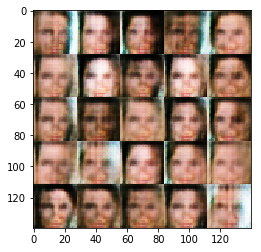

Epoch 1/1... Batch 1110... Discriminator Loss: 1.4643... Generator Loss: 0.7826
Epoch 1/1... Batch 1120... Discriminator Loss: 1.4478... Generator Loss: 0.8003
Epoch 1/1... Batch 1130... Discriminator Loss: 1.5358... Generator Loss: 0.7019
Epoch 1/1... Batch 1140... Discriminator Loss: 1.4615... Generator Loss: 0.8072
Epoch 1/1... Batch 1150... Discriminator Loss: 1.4066... Generator Loss: 0.8125
Epoch 1/1... Batch 1160... Discriminator Loss: 1.3945... Generator Loss: 0.7533
Epoch 1/1... Batch 1170... Discriminator Loss: 1.4137... Generator Loss: 0.7355
Epoch 1/1... Batch 1180... Discriminator Loss: 1.4872... Generator Loss: 0.7801
Epoch 1/1... Batch 1190... Discriminator Loss: 1.3359... Generator Loss: 0.8028
Epoch 1/1... Batch 1200... Discriminator Loss: 1.4556... Generator Loss: 0.8107


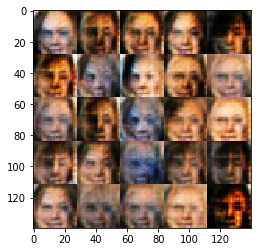

Epoch 1/1... Batch 1210... Discriminator Loss: 1.4805... Generator Loss: 0.7745
Epoch 1/1... Batch 1220... Discriminator Loss: 1.4196... Generator Loss: 0.8583
Epoch 1/1... Batch 1230... Discriminator Loss: 1.4709... Generator Loss: 0.9294
Epoch 1/1... Batch 1240... Discriminator Loss: 1.4331... Generator Loss: 0.8010
Epoch 1/1... Batch 1250... Discriminator Loss: 1.4032... Generator Loss: 0.6977
Epoch 1/1... Batch 1260... Discriminator Loss: 1.4313... Generator Loss: 0.7243
Epoch 1/1... Batch 1270... Discriminator Loss: 1.3819... Generator Loss: 0.8264
Epoch 1/1... Batch 1280... Discriminator Loss: 1.4273... Generator Loss: 0.7793
Epoch 1/1... Batch 1290... Discriminator Loss: 1.4634... Generator Loss: 0.8531
Epoch 1/1... Batch 1300... Discriminator Loss: 1.4853... Generator Loss: 0.8520


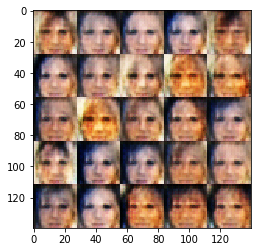

Epoch 1/1... Batch 1310... Discriminator Loss: 1.3708... Generator Loss: 0.8115
Epoch 1/1... Batch 1320... Discriminator Loss: 1.4164... Generator Loss: 0.7513
Epoch 1/1... Batch 1330... Discriminator Loss: 1.5193... Generator Loss: 0.6472
Epoch 1/1... Batch 1340... Discriminator Loss: 1.3926... Generator Loss: 0.8189
Epoch 1/1... Batch 1350... Discriminator Loss: 1.4957... Generator Loss: 0.6836
Epoch 1/1... Batch 1360... Discriminator Loss: 1.4578... Generator Loss: 0.7421
Epoch 1/1... Batch 1370... Discriminator Loss: 1.3979... Generator Loss: 0.8841
Epoch 1/1... Batch 1380... Discriminator Loss: 1.4068... Generator Loss: 0.8571
Epoch 1/1... Batch 1390... Discriminator Loss: 1.4408... Generator Loss: 0.7704
Epoch 1/1... Batch 1400... Discriminator Loss: 1.4910... Generator Loss: 0.7663


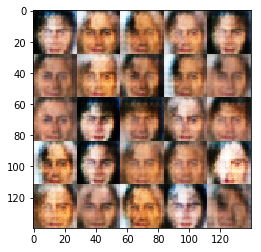

Epoch 1/1... Batch 1410... Discriminator Loss: 1.5024... Generator Loss: 0.6448
Epoch 1/1... Batch 1420... Discriminator Loss: 1.4793... Generator Loss: 0.7153
Epoch 1/1... Batch 1430... Discriminator Loss: 1.5510... Generator Loss: 0.7508
Epoch 1/1... Batch 1440... Discriminator Loss: 1.5499... Generator Loss: 0.7097
Epoch 1/1... Batch 1450... Discriminator Loss: 1.3785... Generator Loss: 0.7719
Epoch 1/1... Batch 1460... Discriminator Loss: 1.4391... Generator Loss: 0.9145
Epoch 1/1... Batch 1470... Discriminator Loss: 1.4123... Generator Loss: 0.7122
Epoch 1/1... Batch 1480... Discriminator Loss: 1.4257... Generator Loss: 0.7795
Epoch 1/1... Batch 1490... Discriminator Loss: 1.4378... Generator Loss: 0.7081
Epoch 1/1... Batch 1500... Discriminator Loss: 1.4143... Generator Loss: 0.8029


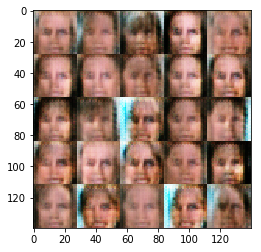

Epoch 1/1... Batch 1510... Discriminator Loss: 1.3831... Generator Loss: 0.6682
Epoch 1/1... Batch 1520... Discriminator Loss: 1.4319... Generator Loss: 0.7843
Epoch 1/1... Batch 1530... Discriminator Loss: 1.4697... Generator Loss: 0.8049
Epoch 1/1... Batch 1540... Discriminator Loss: 1.4965... Generator Loss: 0.7733
Epoch 1/1... Batch 1550... Discriminator Loss: 1.4819... Generator Loss: 0.8027
Epoch 1/1... Batch 1560... Discriminator Loss: 1.4591... Generator Loss: 0.8063
Epoch 1/1... Batch 1570... Discriminator Loss: 1.3709... Generator Loss: 0.8329
Epoch 1/1... Batch 1580... Discriminator Loss: 1.4728... Generator Loss: 0.7680
Epoch 1/1... Batch 1590... Discriminator Loss: 1.5027... Generator Loss: 0.8780
Epoch 1/1... Batch 1600... Discriminator Loss: 1.5233... Generator Loss: 0.7030


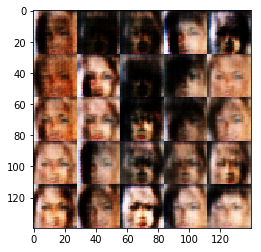

Epoch 1/1... Batch 1610... Discriminator Loss: 1.5898... Generator Loss: 0.7019
Epoch 1/1... Batch 1620... Discriminator Loss: 1.3785... Generator Loss: 0.7718
Epoch 1/1... Batch 1630... Discriminator Loss: 1.3684... Generator Loss: 0.7829
Epoch 1/1... Batch 1640... Discriminator Loss: 1.4381... Generator Loss: 0.8175
Epoch 1/1... Batch 1650... Discriminator Loss: 1.4573... Generator Loss: 0.7411
Epoch 1/1... Batch 1660... Discriminator Loss: 1.4081... Generator Loss: 0.7935
Epoch 1/1... Batch 1670... Discriminator Loss: 1.3802... Generator Loss: 0.6755
Epoch 1/1... Batch 1680... Discriminator Loss: 1.3914... Generator Loss: 0.9002
Epoch 1/1... Batch 1690... Discriminator Loss: 1.4888... Generator Loss: 0.7454
Epoch 1/1... Batch 1700... Discriminator Loss: 1.3669... Generator Loss: 0.8574


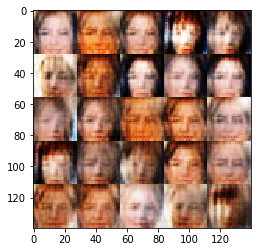

Epoch 1/1... Batch 1710... Discriminator Loss: 1.3998... Generator Loss: 0.8380
Epoch 1/1... Batch 1720... Discriminator Loss: 1.4298... Generator Loss: 0.6373
Epoch 1/1... Batch 1730... Discriminator Loss: 1.4279... Generator Loss: 0.7259
Epoch 1/1... Batch 1740... Discriminator Loss: 1.5436... Generator Loss: 0.7221
Epoch 1/1... Batch 1750... Discriminator Loss: 1.4309... Generator Loss: 1.0019
Epoch 1/1... Batch 1760... Discriminator Loss: 1.3648... Generator Loss: 0.7728
Epoch 1/1... Batch 1770... Discriminator Loss: 1.3914... Generator Loss: 0.8338
Epoch 1/1... Batch 1780... Discriminator Loss: 1.4111... Generator Loss: 0.6823
Epoch 1/1... Batch 1790... Discriminator Loss: 1.3847... Generator Loss: 0.8834
Epoch 1/1... Batch 1800... Discriminator Loss: 1.3404... Generator Loss: 0.7882


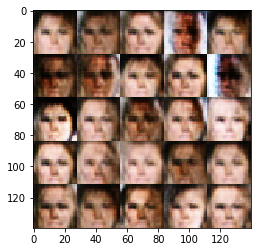

Epoch 1/1... Batch 1810... Discriminator Loss: 1.4858... Generator Loss: 0.7596
Epoch 1/1... Batch 1820... Discriminator Loss: 1.4600... Generator Loss: 0.7757
Epoch 1/1... Batch 1830... Discriminator Loss: 1.3774... Generator Loss: 0.8389
Epoch 1/1... Batch 1840... Discriminator Loss: 1.4007... Generator Loss: 0.7960
Epoch 1/1... Batch 1850... Discriminator Loss: 1.4436... Generator Loss: 0.7613
Epoch 1/1... Batch 1860... Discriminator Loss: 1.4037... Generator Loss: 0.7090
Epoch 1/1... Batch 1870... Discriminator Loss: 1.3890... Generator Loss: 0.7605
Epoch 1/1... Batch 1880... Discriminator Loss: 1.4329... Generator Loss: 0.6287
Epoch 1/1... Batch 1890... Discriminator Loss: 1.4919... Generator Loss: 0.7687
Epoch 1/1... Batch 1900... Discriminator Loss: 1.5131... Generator Loss: 0.6865


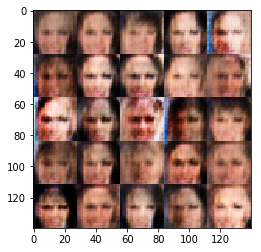

Epoch 1/1... Batch 1910... Discriminator Loss: 1.3137... Generator Loss: 0.7587
Epoch 1/1... Batch 1920... Discriminator Loss: 1.4218... Generator Loss: 0.7472
Epoch 1/1... Batch 1930... Discriminator Loss: 1.3655... Generator Loss: 0.8689
Epoch 1/1... Batch 1940... Discriminator Loss: 1.4025... Generator Loss: 0.7335
Epoch 1/1... Batch 1950... Discriminator Loss: 1.3746... Generator Loss: 0.7301
Epoch 1/1... Batch 1960... Discriminator Loss: 1.4133... Generator Loss: 0.7706
Epoch 1/1... Batch 1970... Discriminator Loss: 1.4279... Generator Loss: 0.8244
Epoch 1/1... Batch 1980... Discriminator Loss: 1.3460... Generator Loss: 0.7869
Epoch 1/1... Batch 1990... Discriminator Loss: 1.4213... Generator Loss: 0.8174
Epoch 1/1... Batch 2000... Discriminator Loss: 1.3976... Generator Loss: 0.8373


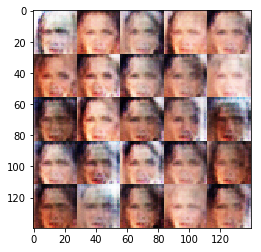

Epoch 1/1... Batch 2010... Discriminator Loss: 1.4974... Generator Loss: 0.7372
Epoch 1/1... Batch 2020... Discriminator Loss: 1.3937... Generator Loss: 0.7515
Epoch 1/1... Batch 2030... Discriminator Loss: 1.4237... Generator Loss: 0.7665
Epoch 1/1... Batch 2040... Discriminator Loss: 1.3825... Generator Loss: 0.7878
Epoch 1/1... Batch 2050... Discriminator Loss: 1.4626... Generator Loss: 0.7382
Epoch 1/1... Batch 2060... Discriminator Loss: 1.3925... Generator Loss: 0.7558
Epoch 1/1... Batch 2070... Discriminator Loss: 1.4063... Generator Loss: 0.8593
Epoch 1/1... Batch 2080... Discriminator Loss: 1.4115... Generator Loss: 0.7893
Epoch 1/1... Batch 2090... Discriminator Loss: 1.3844... Generator Loss: 0.7377
Epoch 1/1... Batch 2100... Discriminator Loss: 1.3920... Generator Loss: 0.8478


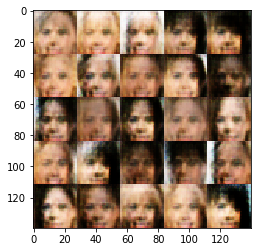

Epoch 1/1... Batch 2110... Discriminator Loss: 1.3952... Generator Loss: 0.8119
Epoch 1/1... Batch 2120... Discriminator Loss: 1.4313... Generator Loss: 0.9427
Epoch 1/1... Batch 2130... Discriminator Loss: 1.3869... Generator Loss: 0.8044
Epoch 1/1... Batch 2140... Discriminator Loss: 1.3900... Generator Loss: 0.7742
Epoch 1/1... Batch 2150... Discriminator Loss: 1.4226... Generator Loss: 0.8926
Epoch 1/1... Batch 2160... Discriminator Loss: 1.4890... Generator Loss: 0.7359
Epoch 1/1... Batch 2170... Discriminator Loss: 1.3364... Generator Loss: 0.8354
Epoch 1/1... Batch 2180... Discriminator Loss: 1.4690... Generator Loss: 0.7109
Epoch 1/1... Batch 2190... Discriminator Loss: 1.4584... Generator Loss: 0.6460
Epoch 1/1... Batch 2200... Discriminator Loss: 1.5395... Generator Loss: 0.7533


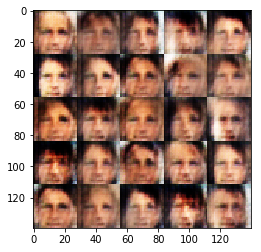

Epoch 1/1... Batch 2210... Discriminator Loss: 1.4239... Generator Loss: 0.8315
Epoch 1/1... Batch 2220... Discriminator Loss: 1.3968... Generator Loss: 0.7290
Epoch 1/1... Batch 2230... Discriminator Loss: 1.4217... Generator Loss: 0.7636
Epoch 1/1... Batch 2240... Discriminator Loss: 1.3788... Generator Loss: 0.6995
Epoch 1/1... Batch 2250... Discriminator Loss: 1.4260... Generator Loss: 0.7984
Epoch 1/1... Batch 2260... Discriminator Loss: 1.4383... Generator Loss: 0.9378
Epoch 1/1... Batch 2270... Discriminator Loss: 1.4773... Generator Loss: 0.7360
Epoch 1/1... Batch 2280... Discriminator Loss: 1.4437... Generator Loss: 0.8217
Epoch 1/1... Batch 2290... Discriminator Loss: 1.4025... Generator Loss: 0.8682
Epoch 1/1... Batch 2300... Discriminator Loss: 1.3947... Generator Loss: 0.7753


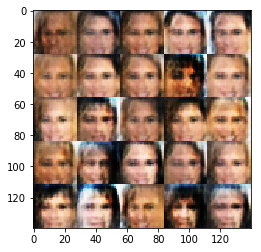

Epoch 1/1... Batch 2310... Discriminator Loss: 1.3666... Generator Loss: 0.8090
Epoch 1/1... Batch 2320... Discriminator Loss: 1.4773... Generator Loss: 0.7377
Epoch 1/1... Batch 2330... Discriminator Loss: 1.4036... Generator Loss: 0.7890
Epoch 1/1... Batch 2340... Discriminator Loss: 1.4184... Generator Loss: 0.7850
Epoch 1/1... Batch 2350... Discriminator Loss: 1.3504... Generator Loss: 0.7067
Epoch 1/1... Batch 2360... Discriminator Loss: 1.4546... Generator Loss: 0.7640
Epoch 1/1... Batch 2370... Discriminator Loss: 1.4479... Generator Loss: 0.9191
Epoch 1/1... Batch 2380... Discriminator Loss: 1.4154... Generator Loss: 0.7920
Epoch 1/1... Batch 2390... Discriminator Loss: 1.4029... Generator Loss: 0.7703
Epoch 1/1... Batch 2400... Discriminator Loss: 1.4476... Generator Loss: 0.8453


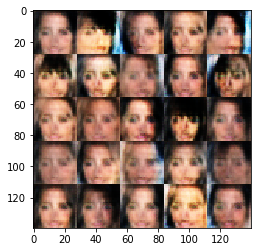

Epoch 1/1... Batch 2410... Discriminator Loss: 1.3821... Generator Loss: 0.8299
Epoch 1/1... Batch 2420... Discriminator Loss: 1.4024... Generator Loss: 0.7861
Epoch 1/1... Batch 2430... Discriminator Loss: 1.3956... Generator Loss: 0.7802
Epoch 1/1... Batch 2440... Discriminator Loss: 1.3680... Generator Loss: 0.8109
Epoch 1/1... Batch 2450... Discriminator Loss: 1.3746... Generator Loss: 0.8443
Epoch 1/1... Batch 2460... Discriminator Loss: 1.3971... Generator Loss: 0.7744
Epoch 1/1... Batch 2470... Discriminator Loss: 1.3819... Generator Loss: 0.7979
Epoch 1/1... Batch 2480... Discriminator Loss: 1.3954... Generator Loss: 0.7863
Epoch 1/1... Batch 2490... Discriminator Loss: 1.4002... Generator Loss: 0.7446
Epoch 1/1... Batch 2500... Discriminator Loss: 1.3796... Generator Loss: 0.8963


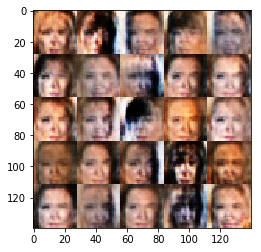

Epoch 1/1... Batch 2510... Discriminator Loss: 1.4427... Generator Loss: 0.8700
Epoch 1/1... Batch 2520... Discriminator Loss: 1.4449... Generator Loss: 0.7804
Epoch 1/1... Batch 2530... Discriminator Loss: 1.4033... Generator Loss: 0.8615
Epoch 1/1... Batch 2540... Discriminator Loss: 1.4259... Generator Loss: 0.6857
Epoch 1/1... Batch 2550... Discriminator Loss: 1.4663... Generator Loss: 0.7633
Epoch 1/1... Batch 2560... Discriminator Loss: 1.4421... Generator Loss: 0.8475
Epoch 1/1... Batch 2570... Discriminator Loss: 1.4554... Generator Loss: 0.7595
Epoch 1/1... Batch 2580... Discriminator Loss: 1.3571... Generator Loss: 0.8608
Epoch 1/1... Batch 2590... Discriminator Loss: 1.4566... Generator Loss: 0.7517
Epoch 1/1... Batch 2600... Discriminator Loss: 1.4542... Generator Loss: 0.7444


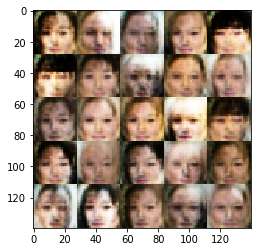

Epoch 1/1... Batch 2610... Discriminator Loss: 1.4149... Generator Loss: 0.6718
Epoch 1/1... Batch 2620... Discriminator Loss: 1.4848... Generator Loss: 0.8013
Epoch 1/1... Batch 2630... Discriminator Loss: 1.4830... Generator Loss: 0.8052
Epoch 1/1... Batch 2640... Discriminator Loss: 1.3968... Generator Loss: 0.9206
Epoch 1/1... Batch 2650... Discriminator Loss: 1.4734... Generator Loss: 0.6421
Epoch 1/1... Batch 2660... Discriminator Loss: 1.4147... Generator Loss: 0.8432
Epoch 1/1... Batch 2670... Discriminator Loss: 1.4826... Generator Loss: 0.8801
Epoch 1/1... Batch 2680... Discriminator Loss: 1.4161... Generator Loss: 0.6484
Epoch 1/1... Batch 2690... Discriminator Loss: 1.3858... Generator Loss: 0.7596
Epoch 1/1... Batch 2700... Discriminator Loss: 1.3965... Generator Loss: 0.6927


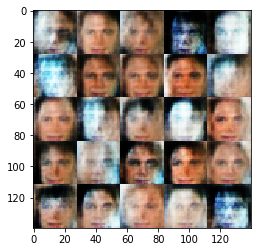

Epoch 1/1... Batch 2710... Discriminator Loss: 1.5196... Generator Loss: 0.7347
Epoch 1/1... Batch 2720... Discriminator Loss: 1.4986... Generator Loss: 0.7550
Epoch 1/1... Batch 2730... Discriminator Loss: 1.3862... Generator Loss: 0.8589
Epoch 1/1... Batch 2740... Discriminator Loss: 1.3878... Generator Loss: 0.8666
Epoch 1/1... Batch 2750... Discriminator Loss: 1.4295... Generator Loss: 0.7543
Epoch 1/1... Batch 2760... Discriminator Loss: 1.3988... Generator Loss: 0.7990
Epoch 1/1... Batch 2770... Discriminator Loss: 1.4166... Generator Loss: 0.8506
Epoch 1/1... Batch 2780... Discriminator Loss: 1.3804... Generator Loss: 0.7144
Epoch 1/1... Batch 2790... Discriminator Loss: 1.4027... Generator Loss: 0.7763
Epoch 1/1... Batch 2800... Discriminator Loss: 1.4322... Generator Loss: 0.7522


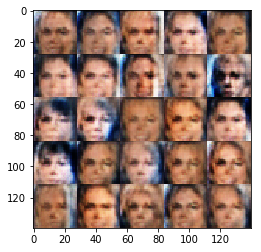

Epoch 1/1... Batch 2810... Discriminator Loss: 1.3670... Generator Loss: 0.7450
Epoch 1/1... Batch 2820... Discriminator Loss: 1.4060... Generator Loss: 0.7170
Epoch 1/1... Batch 2830... Discriminator Loss: 1.3965... Generator Loss: 0.7562
Epoch 1/1... Batch 2840... Discriminator Loss: 1.4284... Generator Loss: 0.8108
Epoch 1/1... Batch 2850... Discriminator Loss: 1.4164... Generator Loss: 0.7043
Epoch 1/1... Batch 2860... Discriminator Loss: 1.3530... Generator Loss: 0.8362
Epoch 1/1... Batch 2870... Discriminator Loss: 1.4133... Generator Loss: 0.8258
Epoch 1/1... Batch 2880... Discriminator Loss: 1.4022... Generator Loss: 0.7747
Epoch 1/1... Batch 2890... Discriminator Loss: 1.4308... Generator Loss: 0.7872
Epoch 1/1... Batch 2900... Discriminator Loss: 1.3871... Generator Loss: 0.7693


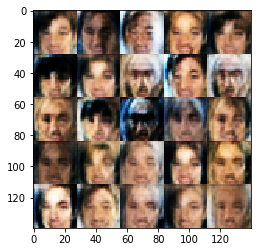

Epoch 1/1... Batch 2910... Discriminator Loss: 1.3785... Generator Loss: 0.6851
Epoch 1/1... Batch 2920... Discriminator Loss: 1.4360... Generator Loss: 0.7146
Epoch 1/1... Batch 2930... Discriminator Loss: 1.4866... Generator Loss: 0.8135
Epoch 1/1... Batch 2940... Discriminator Loss: 1.4639... Generator Loss: 0.8557
Epoch 1/1... Batch 2950... Discriminator Loss: 1.3833... Generator Loss: 0.7809
Epoch 1/1... Batch 2960... Discriminator Loss: 1.3979... Generator Loss: 0.8055
Epoch 1/1... Batch 2970... Discriminator Loss: 1.3994... Generator Loss: 0.7743
Epoch 1/1... Batch 2980... Discriminator Loss: 1.3839... Generator Loss: 0.8202
Epoch 1/1... Batch 2990... Discriminator Loss: 1.4369... Generator Loss: 0.7178
Epoch 1/1... Batch 3000... Discriminator Loss: 1.3896... Generator Loss: 0.7610


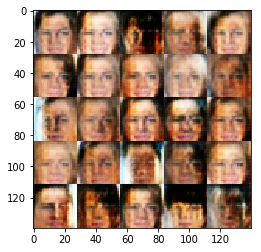

Epoch 1/1... Batch 3010... Discriminator Loss: 1.4002... Generator Loss: 0.8688
Epoch 1/1... Batch 3020... Discriminator Loss: 1.3831... Generator Loss: 0.7944
Epoch 1/1... Batch 3030... Discriminator Loss: 1.3963... Generator Loss: 0.7455
Epoch 1/1... Batch 3040... Discriminator Loss: 1.4338... Generator Loss: 0.8040
Epoch 1/1... Batch 3050... Discriminator Loss: 1.3965... Generator Loss: 0.9206
Epoch 1/1... Batch 3060... Discriminator Loss: 1.4066... Generator Loss: 0.7261
Epoch 1/1... Batch 3070... Discriminator Loss: 1.5835... Generator Loss: 0.5671
Epoch 1/1... Batch 3080... Discriminator Loss: 1.4611... Generator Loss: 0.9109
Epoch 1/1... Batch 3090... Discriminator Loss: 1.3998... Generator Loss: 0.8238
Epoch 1/1... Batch 3100... Discriminator Loss: 1.3881... Generator Loss: 0.8321


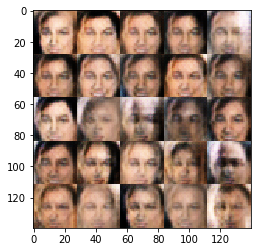

Epoch 1/1... Batch 3110... Discriminator Loss: 1.4374... Generator Loss: 0.8091
Epoch 1/1... Batch 3120... Discriminator Loss: 1.3852... Generator Loss: 0.7936
Epoch 1/1... Batch 3130... Discriminator Loss: 1.4334... Generator Loss: 0.7584
Epoch 1/1... Batch 3140... Discriminator Loss: 1.3882... Generator Loss: 0.8310
Epoch 1/1... Batch 3150... Discriminator Loss: 1.3349... Generator Loss: 0.7769
Epoch 1/1... Batch 3160... Discriminator Loss: 1.4523... Generator Loss: 0.8169


In [19]:
batch_size = 64
z_dim = 100
learning_rate = 0.0005
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.